In [1]:
# Final Project on Charged Particle in Electromagnetic  Field by Adrian
# Velazquez-Martinez, WIP

In [ ]:
# change for where you have stored the train.txt file
# if using google collab, you will need to setup the drive
trainpath = ("./data_lorentz/train.txt")

# SympNet Implementation


In [5]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

def load_dataset(txt_file="./data_lorentz/train.txt", train_size=1200):
    # The provided file has columns: [v1, v2, x1, x2]
    data = np.loadtxt(txt_file)  # shape: [1500, 4]
    # Swap the order so that each state is (x1, x2, v1, v2)
    data_swapped = data[:, [2, 3, 0, 1]]

    # Form training pairs:
    # For i=1...train_size, let input = data_swapped[i-1] (i.e. state_{i-1})
    # and target = data_swapped[i] (i.e. state_i)
    X_in = data_swapped[:train_size]
    Y_out = data_swapped[1:train_size+1]

    X = torch.tensor(X_in, dtype=torch.float32)
    Y = torch.tensor(Y_out, dtype=torch.float32)

    dataset = TensorDataset(X, Y)
    return data_swapped, dataset

# Load data (1500 steps)
data_swapped, dataset = load_dataset("./data_lorentz/train.txt", train_size=1200)

In [6]:
import torch
import torch.nn as nn
from typing import Callable, List

# ---------------------------------------------------------------------------
# Utility
# ---------------------------------------------------------------------------

def _build_mlp(in_dim: int,
               out_dim: int,
               hidden_dim: int,
               n_layers: int,
               act: Callable[[], nn.Module]) -> nn.Sequential:
    """Builds a simple MLP with *n_layers* hidden layers.
    The final layer has **no activation** so that the caller can decide.
    """
    layers: List[nn.Module] = []
    dims = [in_dim] + [hidden_dim] * n_layers + [out_dim]
    for i in range(len(dims) - 2):
        layers.append(nn.Linear(dims[i], dims[i + 1]))
        layers.append(act())
    layers.append(nn.Linear(dims[-2], dims[-1]))
    return nn.Sequential(*layers)

def _orthogonal_init(m: nn.Module, gain: float = 1.0):
    if isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight, gain=gain)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# ---------------------------------------------------------------------------
# Symplectic Coupling Block
# ---------------------------------------------------------------------------

class Coupling(nn.Module):
    """A symplectic coupling block with learnable scaling factors.

    Given input *z = [p, q]* of even dimension *d*, update

        p' = p + s1 * φ1(q)
        q' = q - s2 * φ2(p')

    where *φ1*, *φ2* are small MLPs and *s1*, *s2* are learnable scalars
    initialised close to 0 so that the initial mapping is close to identity.
    """

    def __init__(self,
                 dim: int,
                 hidden: int = 64,
                 mlp_layers: int = 1,
                 act: Callable[[], nn.Module] = nn.Tanh,
                 scale_init: float = 0.0):
        super().__init__()
        if dim % 2 != 0:
            raise ValueError("Dimension must be even for coupling split.")
        self.d = dim // 2

        self.phi1 = _build_mlp(self.d, self.d, hidden, mlp_layers, act)
        self.phi2 = _build_mlp(self.d, self.d, hidden, mlp_layers, act)

        # Learnable (scalar) step sizes initialised close to zero
        self.scale1 = nn.Parameter(torch.full((1,), scale_init))
        self.scale2 = nn.Parameter(torch.full((1,), scale_init))

        # Initialise weights orthogonally for stability
        self.apply(_orthogonal_init)

    # --------------------------------------------------------------------- #
    # Forward / Inverse
    # --------------------------------------------------------------------- #

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        p, q = z.split(self.d, dim=-1)
        p_new = p + self.scale1 * self.phi1(q)
        q_new = q - self.scale2 * self.phi2(p_new)
        return torch.cat([p_new, q_new], dim=-1)

    def inverse(self, z: torch.Tensor) -> torch.Tensor:
        """Exact inverse obtained by reversing the coupling updates."""
        p_new, q_new = z.split(self.d, dim=-1)
        q = q_new + self.scale2 * self.phi2(p_new)
        p = p_new - self.scale1 * self.phi1(q)
        return torch.cat([p, q], dim=-1)

# ---------------------------------------------------------------------------
# SympNet
# ---------------------------------------------------------------------------

class SympNet(nn.Module):
    """Stack of symplectic coupling blocks.

    Parameters
    ----------
    dim : int
        Total phase‑space dimension (must be even).
    hidden : int
        Hidden dimension of each MLP inside a coupling block.
    blocks : int
        Number of coupling blocks to stack.
    mlp_layers : int
        Number of hidden layers inside each φ MLP.
    act_name : {"tanh", "relu"}
        Activation function to use.
    scale_init : float, optional
        Initial value for learnable step‑size scalars in each block (default: 0.0).
    """

    _ACTS = {
        "tanh": nn.Tanh,
        "relu": nn.ReLU,
    }

    def __init__(self,
                 dim: int = 4,
                 hidden: int = 64,
                 blocks: int = 4,
                 mlp_layers: int = 1,
                 act_name: str = "tanh",
                 scale_init: float = 0.0):
        super().__init__()
        if act_name not in self._ACTS:
            raise ValueError(f"Unknown activation '{act_name}'. Choose 'tanh' or 'relu'.")
        act = self._ACTS[act_name]

        self.blocks = nn.ModuleList([
            Coupling(dim, hidden, mlp_layers, act, scale_init)
            for _ in range(blocks)
        ])

    # --------------------------------------------------------------------- #
    # Forward / Inverse
    # --------------------------------------------------------------------- #

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        for block in self.blocks:
            z = block(z)
        return z

    def inverse(self, z: torch.Tensor) -> torch.Tensor:
        for block in reversed(self.blocks):
            z = block.inverse(z)
        return z

    # --------------------------------------------------------------------- #
    # Utility
    # --------------------------------------------------------------------- #

    @torch.no_grad()
    def rollout(self, z0: torch.Tensor, steps: int) -> torch.Tensor:
        """Roll out the network for a fixed number of steps.

        Returns a tensor of shape *(steps + 1, *z0.shape)* containing the
        trajectory, including the initial state.
        """
        zs = [z0]
        z = z0
        for _ in range(steps):
            z = self.forward(z)
            zs.append(z)
        return torch.stack(zs)

In [7]:
import torch.nn as nn

class Coupling(nn.Module):
    """
    A symplectic coupling block that splits the input (of even dimension)
    into two halves, then updates one half using a small MLP of the other half.
    This block is designed so that the overall mapping is symplectic.
    """
    def __init__(self, d, hidden=64, act=nn.Tanh):
        super().__init__()
        self.d = d // 2  # each half dimension
        self.phi1 = nn.Sequential(
            nn.Linear(self.d, hidden),
            act(),
            nn.Linear(hidden, self.d)
        )
        self.phi2 = nn.Sequential(
            nn.Linear(self.d, hidden),
            act(),
            nn.Linear(hidden, self.d)
        )

    def forward(self, z):
        # Split z into two halves: p and q. Here we interpret z = [x, v]
        p, q = z.split(self.d, dim=-1)
        # Update p using q then update q using the new p.
        p_new = p + self.phi1(q)
        q_new = q - self.phi2(p_new)
        return torch.cat([p_new, q_new], dim=-1)

class SympNet(nn.Module):
    """
    A stack of symplectic coupling blocks. The input and output are both 4D.
    The activation is chosen via a string ("tanh", "relu", etc.).
    """
    def __init__(self, dim=4, hidden=64, layers=4, act_name="tanh"):
        super().__init__()
        act = {"tanh": nn.Tanh, "relu": nn.ReLU, "silu": nn.SiLU}[act_name]
        self.blocks = nn.ModuleList([Coupling(dim, hidden, act) for _ in range(layers)])

    def forward(self, z):
        for block in self.blocks:
            z = block(z)
        return z

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
from torch.utils.data import DataLoader

# Create DataLoader from the dataset
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

net = SympNet(dim=4, hidden=64, layers=4, act_name="tanh").to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

n_epochs = 250
for epoch in range(n_epochs):
    net.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = net(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*xb.size(0)
    epoch_loss = total_loss / len(dataset)
    if (epoch+1) % 25 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {epoch_loss:.6e}")

Epoch 25/250 - Loss: 9.943472e-04
Epoch 50/250 - Loss: 4.846829e-04
Epoch 75/250 - Loss: 3.555586e-04
Epoch 100/250 - Loss: 2.511657e-04
Epoch 125/250 - Loss: 1.842909e-04
Epoch 150/250 - Loss: 1.512809e-04
Epoch 175/250 - Loss: 1.001592e-04
Epoch 200/250 - Loss: 7.852456e-05
Epoch 225/250 - Loss: 6.079268e-05
Epoch 250/250 - Loss: 5.099285e-05


Average rollout MSE: 0.23256674539118563


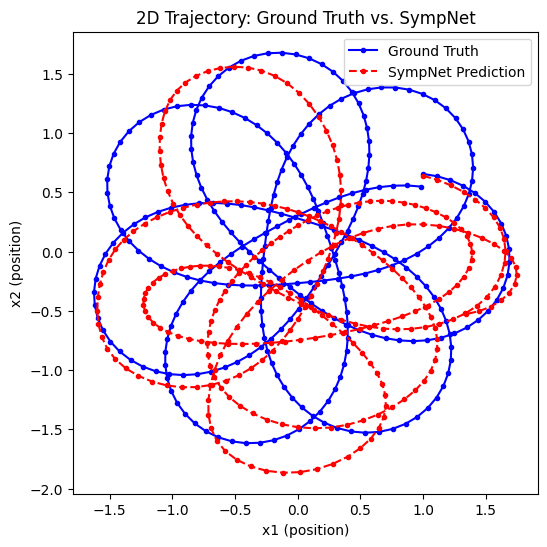

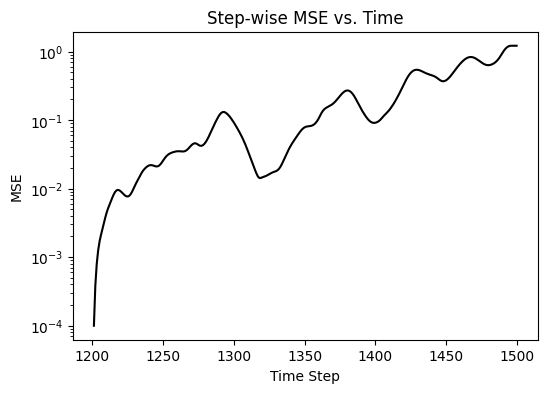

In [9]:
# Starting state: the last training state is at index 1199 (i.e. step 1200)
start_state = torch.tensor(data_swapped[1199], dtype=torch.float32, device=device).unsqueeze(0)
rollout_steps = 300  # for steps 1201 to 1500

net.eval()
predicted = []
with torch.no_grad():
    z = start_state
    for _ in range(rollout_steps):
        z = net(z)
        predicted.append(z.squeeze(0).cpu().numpy())
predicted = np.stack(predicted)  # shape: [300, 4]

# Ground truth for steps 1201 to 1500 (in order (x, v))
gt = data_swapped[1200:]  # shape: [300, 4]

# Compute step-wise MSE
mse = np.mean((predicted - gt)**2, axis=1)
print("Average rollout MSE:", np.mean(mse))

# Plot the trajectory: we plot the positions (first two columns)
plt.figure(figsize=(6,6))
plt.plot(gt[:, 0], gt[:, 1], 'b.-', label="Ground Truth")
plt.plot(predicted[:, 0], predicted[:, 1], 'r.--', label="SympNet Prediction")
plt.xlabel("x1 (position)")
plt.ylabel("x2 (position)")
plt.title("2D Trajectory: Ground Truth vs. SympNet")
plt.legend()
plt.show()

# Plot the step-wise MSE (log scale)
plt.figure(figsize=(6,4))
plt.plot(np.arange(1201, 1501), mse, 'k-')
plt.xlabel("Time Step")
plt.ylabel("MSE")
plt.yscale("log")
plt.title("Step-wise MSE vs. Time")
plt.show()

Running: act=tanh, optimizer=adam
Running: act=tanh, optimizer=sgd
Running: act=relu, optimizer=adam
Running: act=relu, optimizer=sgd


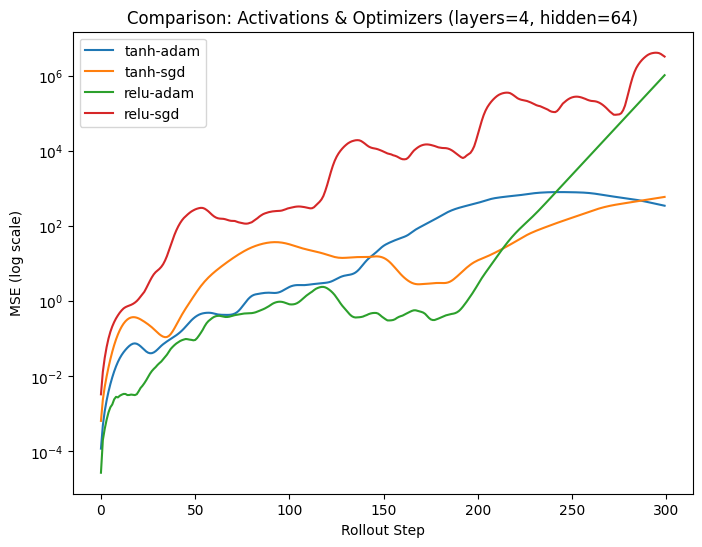

Running: layers=2, hidden=32, act=tanh, optimizer=adam
Running: layers=2, hidden=64, act=tanh, optimizer=adam
Running: layers=2, hidden=128, act=tanh, optimizer=adam
Running: layers=4, hidden=32, act=tanh, optimizer=adam
Running: layers=4, hidden=64, act=tanh, optimizer=adam
Running: layers=4, hidden=128, act=tanh, optimizer=adam
Running: layers=8, hidden=32, act=tanh, optimizer=adam
Running: layers=8, hidden=64, act=tanh, optimizer=adam
Running: layers=8, hidden=128, act=tanh, optimizer=adam
Running: layers=12, hidden=32, act=tanh, optimizer=adam
Running: layers=12, hidden=64, act=tanh, optimizer=adam
Running: layers=12, hidden=128, act=tanh, optimizer=adam


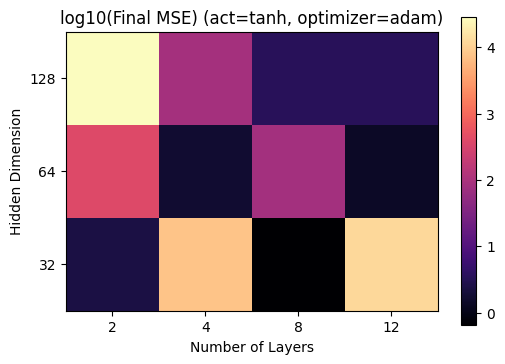

In [ ]:
# I will leave this here, but its more of an experiment that I was going
# over when doing the first implementation and trying to find the most 
# optimized optimizer. Ofc, I just settled for ADAM and a TanH activator. 

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Data loading function (assumes the state is re‐ordered as (x, v))
def load_dataset(txt_file="./data_lorentz/train.txt", train_size=1200):
    data = np.loadtxt(txt_file)         # [1500,4]: columns = [v1, v2, x1, x2]
    # Reorder so that each state is (x1, x2, v1, v2)
    data_swapped = data[:, [2, 3, 0, 1]]
    X_in  = data_swapped[:train_size]
    Y_out = data_swapped[1:train_size+1]
    X = torch.tensor(X_in, dtype=torch.float32)
    Y = torch.tensor(Y_out, dtype=torch.float32)
    dataset = TensorDataset(X, Y)
    return data_swapped, dataset

# Define the Coupling block and SympNet (as before)
class Coupling(nn.Module):
    def __init__(self, d, hidden=64, act=nn.Tanh):
        super().__init__()
        self.d = d // 2
        self.phi1 = nn.Sequential(
            nn.Linear(self.d, hidden),
            act(),
            nn.Linear(hidden, self.d)
        )
        self.phi2 = nn.Sequential(
            nn.Linear(self.d, hidden),
            act(),
            nn.Linear(hidden, self.d)
        )
    def forward(self, z):
        p, q = z.split(self.d, dim=-1)
        p_new = p + self.phi1(q)
        q_new = q - self.phi2(p_new)
        return torch.cat([p_new, q_new], dim=-1)

class SympNet(nn.Module):
    def __init__(self, dim=4, hidden=64, layers=4, act_name="tanh"):
        super().__init__()
        act = {"tanh": nn.Tanh, "relu": nn.ReLU, "silu": nn.SiLU}[act_name]
        self.blocks = nn.ModuleList([Coupling(dim, hidden, act) for _ in range(layers)])
    def forward(self, z):
        for block in self.blocks:
            z = block(z)
        return z

# Extended one_run function to include optimizer type
def one_run(layers, hidden, act="tanh", optimizer_type="adam",
            epochs=250, batch_size=128, rollout=300, device="cpu"):
    data_swapped, dataset = load_dataset()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    net = SympNet(dim=4, hidden=hidden, layers=layers, act_name=act).to(device)

    # Choose the optimizer based on the parameter
    if optimizer_type.lower() == "adam":
        optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    elif optimizer_type.lower() == "sgd":
        optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)
    elif optimizer_type.lower() == "rmsprop":
        optimizer = torch.optim.RMSprop(net.parameters(), lr=1e-3)
    else:
        raise ValueError("Unsupported optimizer type")

    loss_fn = nn.MSELoss()

    net.train()
    for epoch in range(epochs):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = net(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Rollout: starting from the last training state (index 1199)
    start_state = torch.tensor(data_swapped[1199], dtype=torch.float32, device=device).unsqueeze(0)
    net.eval()
    preds = []
    with torch.no_grad():
        z = start_state
        for _ in range(rollout):
            z = net(z)
            preds.append(z.squeeze(0).cpu().numpy())
    preds = np.stack(preds)
    gt = data_swapped[1200:]
    mse = np.mean((preds - gt)**2, axis=1)
    return mse

# Function to compare activation functions and optimizer types on a fixed network size.
def compare_activations_and_optimizers(act_list=["tanh", "relu"],
                                       optimizer_list=["adam", "sgd"],
                                       layers=4, hidden=64, epochs=250,
                                       rollout=300, device="cpu"):
    results = {}
    for act in act_list:
        for opt_type in optimizer_list:
            print(f"Running: act={act}, optimizer={opt_type}")
            mse_vec = one_run(layers, hidden, act=act, optimizer_type=opt_type,
                              epochs=epochs, rollout=rollout, device=device)
            key = f"{act}-{opt_type}"
            results[key] = mse_vec

    plt.figure(figsize=(8,6))
    steps = np.arange(rollout)
    for key, mse_vec in results.items():
        plt.plot(steps, mse_vec, label=key)
    plt.yscale("log")
    plt.xlabel("Rollout Step")
    plt.ylabel("MSE (log scale)")
    plt.title(f"Comparison: Activations & Optimizers (layers={layers}, hidden={hidden})")
    plt.legend()
    plt.show()

# Function to compare different network sizes (layers & hidden) for a given activation and optimizer.
def compare_hyperparams(layers_list, hidden_list, act="tanh", optimizer_type="adam",
                        epochs=250, rollout=300, device="cpu"):
    results = {}
    for L in layers_list:
        for H in hidden_list:
            print(f"Running: layers={L}, hidden={H}, act={act}, optimizer={optimizer_type}")
            mse_vec = one_run(L, H, act=act, optimizer_type=optimizer_type,
                              epochs=epochs, rollout=rollout, device=device)
            results[(L, H)] = mse_vec[-1]  # final step MSE
    final_err = np.zeros((len(hidden_list), len(layers_list)))
    for i, H in enumerate(hidden_list):
        for j, L in enumerate(layers_list):
            final_err[i, j] = results[(L, H)]
    plt.figure(figsize=(6,4))
    im = plt.imshow(np.log10(final_err), cmap="magma", origin="lower")
    plt.xticks(range(len(layers_list)), layers_list)
    plt.yticks(range(len(hidden_list)), hidden_list)
    plt.xlabel("Number of Layers")
    plt.ylabel("Hidden Dimension")
    plt.title(f"log10(Final MSE) (act={act}, optimizer={optimizer_type})")
    plt.colorbar(im)
    plt.show()

device = "cuda" if torch.cuda.is_available() else "cpu"

# Compare activations and optimizers
compare_activations_and_optimizers(act_list=["tanh", "relu"], optimizer_list=["adam", "sgd"],
                                   layers=4, hidden=64, epochs=250, rollout=300, device=device)

# Now compare hyperparameters for the best combination (say, using tanh and adam)
layers_list = [2, 4, 8, 12]
hidden_list = [32, 64, 128]
compare_hyperparams(layers_list, hidden_list, act="tanh", optimizer_type="adam",
                    epochs=250, rollout=300, device=device)

# VP-PNN

epoch  30/300  MSE = 2.2030e-03
epoch  60/300  MSE = 1.6612e-03
epoch  90/300  MSE = 1.3450e-03
epoch 120/300  MSE = 1.1619e-03
epoch 150/300  MSE = 1.0322e-03
epoch 180/300  MSE = 1.1309e-03
epoch 210/300  MSE = 8.4852e-04
epoch 240/300  MSE = 7.6400e-04
epoch 270/300  MSE = 9.8314e-04
epoch 300/300  MSE = 6.5325e-04


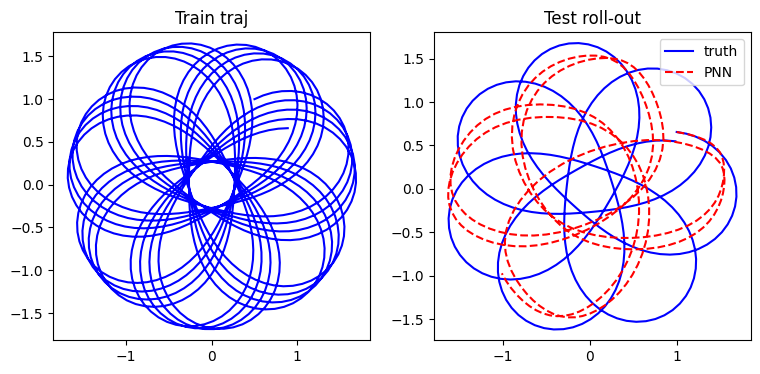

In [49]:
# ======================  COMPLETE PNN DEMO CELL  =============================
import sys, types, os, numpy as np, torch, matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

# --- paths -------------------------------------------------------------------
REPO_ROOT = os.path.abspath("./learner")      # outer folder that contains learner/
DATA_FILE = "./data_lorentz/train.txt"

if REPO_ROOT not in sys.path:
    sys.path.append(REPO_ROOT)

# stub optional sub‑packages
for name in ("learner.data", "learner.integrator",
             "learner.integrator.hamiltonian", "learner.brain"):
    if name not in sys.modules:
        sys.modules[name] = types.ModuleType(name)
sys.modules["learner.brain"].Brain = object
sys.modules["learner.integrator.hamiltonian"].SV = object

# --- import building blocks --------------------------------------------------
from learner.nn.inn     import INN
from learner.nn.sympnet import LASympNet          # leap‑frog additive SympNet
from learner.nn.pnn     import PNN

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- build sub‑nets ----------------------------------------------------------
# INN: more channels, additive coupling (volume preserving)
inn     = INN(4, 2, layers=4, sublayers=3, subwidth=128,
              activation="tanh", volume_preserving=True)

# SympNet: deeper & wider
sympnet = LASympNet(4, 128, 10, activation="tanh")

# wrap with 2 recurrent applications
model   = PNN(inn, sympnet, recurrent=2).to(device)

# optimiser with LR schedule
opt = torch.optim.AdamW(model.parameters(), lr=2e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=100, gamma=0.3)

# --- data loader -------------------------------------------------------------
raw   = np.loadtxt(DATA_FILE, dtype=np.float32)[:, [2,3,0,1]]
train = raw[:1200];   test = raw[1200:]

X = torch.tensor(train[:-1], dtype=torch.float32)
Y = torch.tensor(train[1:],  dtype=torch.float32)
loader = DataLoader(TensorDataset(X, Y), batch_size=256, shuffle=True)

# --- training (MSE) ----------------------------------------------------------
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
mse = torch.nn.MSELoss()

for ep in range(1, 301):
    tot = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = mse(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        tot += loss.item()*xb.size(0)
    if ep % 30 == 0:
        print(f"epoch {ep:3d}/300  MSE = {tot/len(loader.dataset):.4e}")

# --- roll‑out on test horizon -----------------------------------------------
model.eval()
with torch.no_grad():
    z = torch.tensor(test[0:1], device=device)
    pred = [z.cpu()]
    for _ in range(len(test)-1):
        z = model(z)
        pred.append(z.cpu())
pred = torch.cat(pred).numpy()

# --- plots -------------------------------------------------------------------
plt.figure(figsize=(9,4))
plt.subplot(1,2,1); plt.plot(train[:,0], train[:,1],'b'); plt.axis("equal"); plt.title("Train traj")
plt.subplot(1,2,2)
plt.plot(test[:,0], test[:,1],'b',label="truth")
plt.plot(pred[:,0], pred[:,1],'r--',label="PNN"); plt.axis("equal"); plt.legend(); plt.title("Test roll‑out")
plt.show()
# =============================================================================

Average step‑wise MSE (positions): 0.895


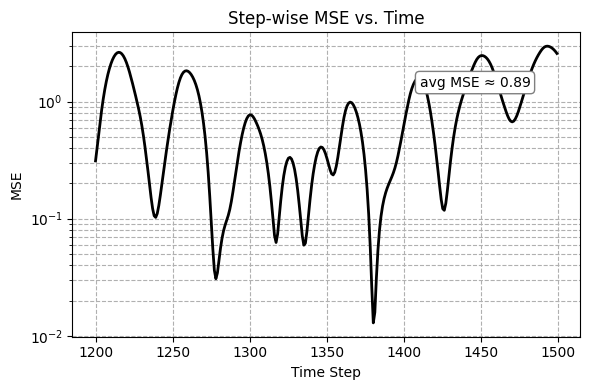

In [60]:
# ---------------------------------------------------------------------------
# VP‑PNN · compute scalar avg‑MSE over rollout and annotate plot
# ---------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

# pred : (T,4) rollout  [x,y,vx,vy]   – already in memory
# test : (T,4) ground truth           – already in memory
# train: (N,4) training split         – already in memory

# 1) per‑step position error
pred_pos = pred[:, :2]
true_pos = test[:, :2]
mse_pos  = np.mean((pred_pos - true_pos)**2, axis=1)

# 2) scalar average over the whole rollout
avg_mse = mse_pos.mean()
print(f"Average step‑wise MSE (positions): {avg_mse:.3f}")

# 3) build x‑axis in absolute time steps
start_step = train.shape[0]          # e.g. 1200
steps = np.arange(start_step, start_step + len(mse_pos))

# 4) plot log‑scale curve and annotate the average
plt.figure(figsize=(6,4))
plt.plot(steps, mse_pos, lw=2, color="k")
plt.yscale("log")
plt.xlabel("Time Step")
plt.ylabel("MSE")
plt.title("Step‑wise MSE vs. Time")

# annotate average value (placed at 70 % of x‑range, 1.5× avg‑MSE)
x_annot = steps[int(0.7*len(steps))]
y_annot = avg_mse * 1.5
plt.text(x_annot, y_annot, f"avg MSE ≈ {avg_mse:.2f}",
         fontsize=10, bbox=dict(boxstyle="round", fc="white", ec="gray"))

plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

# PINN Implementation & Testing


   0 | total 1.380e+00 | data 1.309e+00 | phys 1.425e-03
 500 | total 1.538e-01 | data 6.692e-03 | phys 2.940e-03
1000 | total 7.532e-03 | data 1.469e-03 | phys 1.189e-04
1500 | total 6.962e-03 | data 1.226e-03 | phys 1.109e-04
2000 | total 3.235e-02 | data 1.374e-03 | phys 6.138e-04
2500 | total 9.379e-03 | data 1.421e-03 | phys 1.513e-04
3000 | total 4.957e-03 | data 6.995e-04 | phys 7.519e-05
3500 | total 6.019e-03 | data 9.004e-04 | phys 9.006e-05
4000 | total 1.775e-02 | data 8.956e-04 | phys 3.224e-04
4500 | total 2.573e-02 | data 8.974e-04 | phys 4.795e-04
5000 | total 4.510e-03 | data 5.740e-04 | phys 5.880e-05
5500 | total 3.703e-03 | data 5.397e-04 | phys 4.098e-05
Learned m=0.8021, q=0.7831
[PINN] average rollout position MSE: 0.903


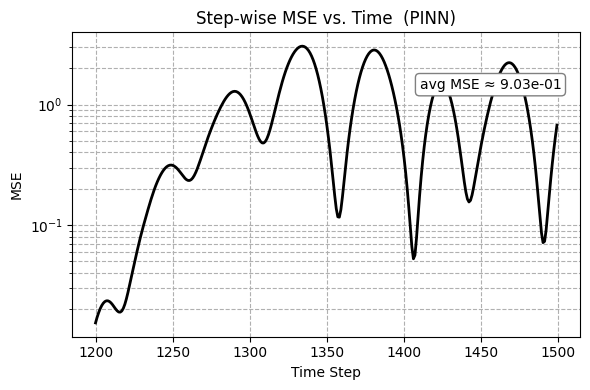

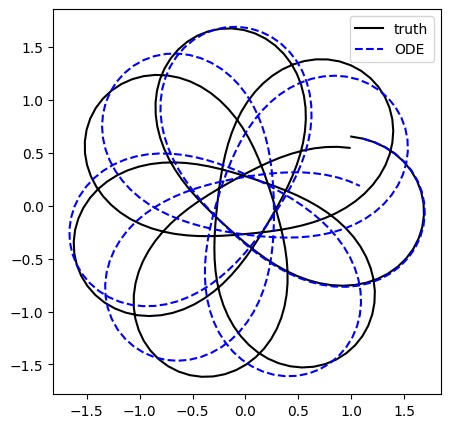

In [63]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# -----------------------------
# 1.  DATA  --------------------
# -----------------------------
train_raw = np.loadtxt(trainpath)   # columns: v1 v2 x1 x2

t_full = np.arange(train_raw.shape[0]) * 0.1   # Δt = 0.1 s
N_TRAIN = 1200

train, test = train_raw[:N_TRAIN], train_raw[N_TRAIN:]

t_train = torch.tensor(t_full[:N_TRAIN], dtype=torch.float32).view(-1, 1)
t_test  = torch.tensor(t_full[N_TRAIN:], dtype=torch.float32).view(-1, 1)

# time → [‑1,1]
t_min, t_max = t_train.min(), t_train.max()
TIME_SCALE = 2.0 / (t_max - t_min)

t_train_n = TIME_SCALE * (t_train - t_min) - 1.0
t_test_n  = TIME_SCALE * (t_test  - t_min) - 1.0

x_train = torch.tensor(train[:, 2:], dtype=torch.float32)
v_train = torch.tensor(train[:, :2], dtype=torch.float32)
x_test  = torch.tensor(test[:, 2:],  dtype=torch.float32)
v_test  = torch.tensor(test[:, :2],  dtype=torch.float32)

# -----------------------------
# 2.  PHYSICS ------------------
# -----------------------------

def B_field(x):  # x: (...,2)
    r = torch.norm(x, dim=-1, keepdim=True) + 1e-12
    Bz = r.squeeze(-1)
    z = torch.zeros_like(Bz)
    return torch.stack([z, z, Bz], dim=-1)


def E_field(x):
    r = torch.norm(x, dim=-1, keepdim=True) + 1e-12
    return -torch.cat([x, torch.zeros_like(r)], dim=-1) / (100.0 * r)

# -----------------------------
# 3.  MLP PINN (Tanh + optional Fourier features)
# -----------------------------

class FourierFeatures(nn.Module):
    """Map 1‑D time input to a higher‑dimensional space with sin/cos bases.
    Helps ReLU/Tanh networks learn high‑frequency behaviour without SIREN.
    """
    def __init__(self, in_dim=1, mapping_size=32, scale=10.0):
        super().__init__()
        B = torch.randn(in_dim, mapping_size) * scale
        self.register_buffer('B', B)

    def forward(self, x):  # x: (N,1)
        # ensure B lives on the same device as x
        B = self.B.to(x.device)
        proj = 2 * np.pi * x @ B  # (N, mapping_size)
        return torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)


class MLP_PINN(nn.Module):
    def __init__(self, hidden=256, depth=5, use_fourier=True):
        super().__init__()
        self.use_fourier = use_fourier
        if use_fourier:
            self.ff = FourierFeatures(mapping_size=32, scale=10.0)
            in_dim = 64  # 32 sin + 32 cos
        else:
            in_dim = 1

        layers = [nn.Linear(in_dim, hidden), nn.Tanh()]
        for _ in range(depth - 1):
            layers += [nn.Linear(hidden, hidden), nn.Tanh()]
        layers.append(nn.Linear(hidden, 4))
        self.net = nn.Sequential(*layers)

        # log‑space physical parameters
        self.log_m = nn.Parameter(torch.zeros(1))
        self.log_q = nn.Parameter(torch.zeros(1))

    def forward(self, t):
        if self.use_fourier:
            t_feat = self.ff(t)
        else:
            t_feat = t
        return self.net(t_feat)

    @property
    def m(self):
        return torch.exp(self.log_m)

    @property
    def q(self):
        return torch.exp(self.log_q)

# instantiate
model = MLP_PINN(use_fourier=True)

# -----------------------------
# 3b.  DEVICE & DATA TRANSFER
# -----------------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# move tensors to the same device as the model
TIME_SCALE = TIME_SCALE.to(device)

t_train_n = t_train_n.to(device)
t_test_n  = t_test_n.to(device)

x_train = x_train.to(device)
v_train = v_train.to(device)
x_test  = x_test.to(device)
v_test  = v_test.to(device)


# -----------------------------
# 4.  Losses
# -----------------------------  Losses -------------------
# -----------------------------
MSE = nn.MSELoss()


def d_dt_phys(y, t_n):  # full Jacobian → physical time
    grads = []
    for i in range(y.shape[1]):
        grad_i = torch.autograd.grad(y[:, i].sum(), t_n, retain_graph=True, create_graph=True)[0]
        grads.append(grad_i)
    return torch.cat(grads, dim=1) * TIME_SCALE


def residual(t_n):
    t_n = t_n.clone().detach().requires_grad_(True)
    y = model(t_n)
    v, x = y[:, :2], y[:, 2:]
    dy = d_dt_phys(y, t_n)
    v_dot, x_dot = dy[:, :2], dy[:, 2:]

    v3 = torch.cat([v, torch.zeros_like(v[:, :1])], dim=-1)
    lorentz_xy = (model.q * (E_field(x) + torch.cross(v3, B_field(x), dim=-1)))[:, :2]

    res_v = model.m * v_dot - lorentz_xy
    res_x = x_dot - v
    return torch.cat([res_v, res_x], dim=-1)

# collocation points across whole time span (train+test)
COLLOC = torch.linspace(t_full.min(), t_full.max(), 3000, device=device).view(-1, 1)
COLLOC_N = TIME_SCALE * (COLLOC - t_min) - 1.0

lambda_phys = 50.0
prior_w = 5e-3


def loss_fn():
    # data fit
    pred = model(t_train_n)
    data_l = MSE(pred[:, :2], v_train) + MSE(pred[:, 2:], x_train)
    # physics
    phys_l = MSE(residual(COLLOC_N), torch.zeros_like(COLLOC_N).repeat(1, 4))
    # weak parameter prior
    prior_l = ((model.m - 1) ** 2 + (model.q - 1) ** 2)
    return data_l + lambda_phys * phys_l + prior_w * prior_l, data_l.detach(), phys_l.detach()

# -----------------------------
# 5.  Training -----------------
# -----------------------------
optimiser = optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 6000
for epoch in range(EPOCHS):
    optimiser.zero_grad()
    total, d_l, p_l = loss_fn()
    total.backward()
    optimiser.step()
    if epoch % 500 == 0:
        print(f"{epoch:4d} | total {total.item():.3e} | data {d_l.item():.3e} | phys {p_l.item():.3e}")

# LBFGS fine‑tune
lbfgs = optim.LBFGS(model.parameters(), max_iter=500, tolerance_grad=1e-9)

def closure():
    lbfgs.zero_grad()
    total, _, _ = loss_fn()
    total.backward()
    return total

lbfgs.step(closure)
print(f"Learned m={model.m.item():.4f}, q={model.q.item():.4f}")

# -----------------------------
# 6.  Evaluation --------------
# -----------------------------
with torch.no_grad():
    pred_test = model(t_test_n)              # (T,4)  [v1,v2,x1,x2]

pred_pinn = pred_test.cpu().numpy()          # <-- add this
test      = torch.cat([v_test, x_test], 1).cpu().numpy()  # to match shape (T,4)
train     = train_raw[:N_TRAIN]                              # already in RAM

# step‑wise MSE plot + scalar average (SympNet style)
import numpy as np, matplotlib.pyplot as plt

pred_pos = pred_pinn[:, 2:]           # PINN outputs [v1,v2,x1,x2] → positions = cols 2:4
true_pos = test[:, 2:]
mse_pos  = np.mean((pred_pos - true_pos)**2, axis=1)

steps = np.arange(N_TRAIN, N_TRAIN + len(mse_pos))
avg_mse = mse_pos.mean()
print(f"[PINN] average rollout position MSE: {avg_mse:.3f}")

plt.figure(figsize=(6,4))
plt.plot(steps, mse_pos, lw=2, color="k")
plt.yscale("log")
plt.xlabel("Time Step")
plt.ylabel("MSE")
plt.title("Step‑wise MSE vs. Time  (PINN)")
plt.text(steps[int(0.7*len(steps))], avg_mse*1.5,
         f"avg MSE ≈ {avg_mse:.2e}",
         fontsize=10, bbox=dict(boxstyle="round", fc="white", ec="gray"))
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

# -----------------------------
# 7.  ODE rollout -------------
# -----------------------------

def accel(x, v, m, q):
    r = torch.norm(x, dim=-1, keepdim=True) + 1e-12
    Bz = r.squeeze(-1)
    B = torch.stack([torch.zeros_like(Bz), torch.zeros_like(Bz), Bz], dim=-1)
    E = -torch.cat([x, torch.zeros_like(r)], dim=-1) / (100.0 * r)
    v3 = torch.cat([v, torch.zeros_like(v[:, :1])], dim=-1)
    return (q * (E + torch.cross(v3, B, dim=-1)))[:, :2] / m


def rk4(x, v, m, q, dt):
    k1v, k1x = accel(x, v, m, q), v
    k2v, k2x = accel(x+0.5*dt*k1x, v+0.5*dt*k1v, m, q), v+0.5*dt*k1v
    k3v, k3x = accel(x+0.5*dt*k2x, v+0.5*dt*k2v, m, q), v+0.5*dt*k2v
    k4v, k4x = accel(x+dt*k3x, v+dt*k3v, m, q), v+dt*k3v
    x_new = x + dt/6*(k1x+2*k2x+2*k3x+k4x)
    v_new = v + dt/6*(k1v+2*k2v+2*k3v+k4v)
    return x_new, v_new

with torch.no_grad():
    m_est, q_est = model.m.item(), model.q.item()

x0, v0 = x_test[0:1].clone(), v_test[0:1].clone()
traj = []
for _ in range(len(t_test)):
    x0, v0 = rk4(x0, v0, m_est, q_est, 0.1)
    traj.append(x0)
traj = torch.cat(traj)

plt.figure(figsize=(5,5))
plt.plot(x_test[:,0].cpu(), x_test[:,1].cpu(), 'k-', label='truth')
plt.plot(traj[:,0].cpu(), traj[:,1].cpu(), 'b--', label='ODE')
plt.axis('equal'); plt.legend(); plt.show()

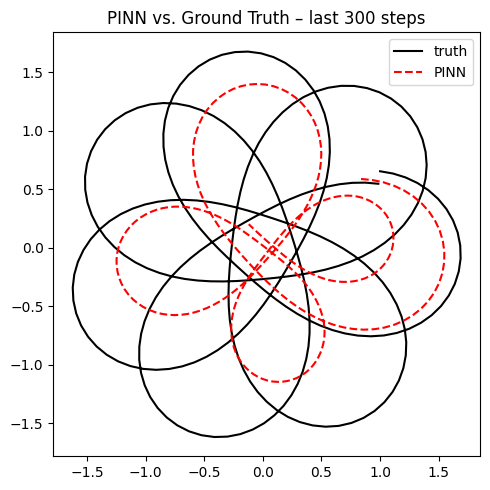

[PINN] average rollout position MSE: 0.903


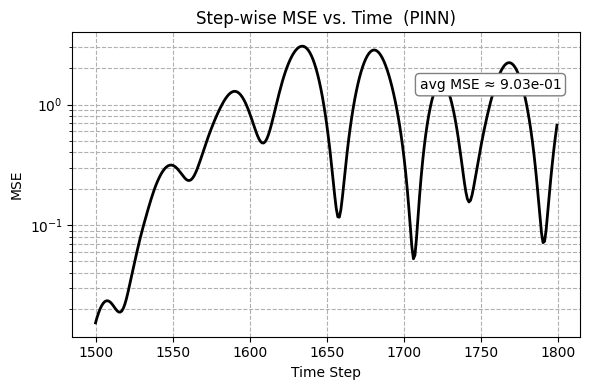

In [65]:
# ---------------------------------------------------------------------------
#  PINN • trajectory overlay (last 300 pts)  +  log‑MSE plot w/ average
# ---------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

# tensors → numpy
T_LAST = 300                                   # how many tail points to show
true_pos_all = x_test.cpu().numpy()            # (T,2)
pred_pos_all = pred_pinn[:, 2:]                # cols 2,3 are [x1,x2]

# ----- 1. trajectory overlay (tail) -----------------------------------------
true_tail = true_pos_all[-T_LAST:]
pred_tail = pred_pos_all[-T_LAST:]

plt.figure(figsize=(5,5))
plt.plot(true_tail[:,0], true_tail[:,1], 'k-',  label='truth')
plt.plot(pred_tail[:,0], pred_tail[:,1], 'r--', label='PINN')
plt.title(f'PINN vs. Ground Truth – last {T_LAST} steps')
plt.axis('equal'); plt.legend(); plt.tight_layout(); plt.show()

# ----- 2. step‑wise MSE & average ------------------------------------------
mse_pos = np.mean((pred_pos_all - true_pos_all)**2, axis=1)
start_step = train_raw.shape[0]                # = 1200
steps = np.arange(start_step, start_step + len(mse_pos))
avg_mse = mse_pos.mean()
print(f"[PINN] average rollout position MSE: {avg_mse:.3f}")

plt.figure(figsize=(6,4))
plt.plot(steps, mse_pos, lw=2, color="k")
plt.yscale("log")
plt.xlabel("Time Step"); plt.ylabel("MSE")
plt.title("Step‑wise MSE vs. Time  (PINN)")
plt.text(steps[int(0.7*len(steps))], avg_mse*1.5,
         f"avg MSE ≈ {avg_mse:.2e}",
         fontsize=10,
         bbox=dict(boxstyle="round", fc="white", ec="gray"))
plt.grid(True, which="both", ls="--")
plt.tight_layout(); plt.show()